## IMAGE COLORING PROJECT

Group Name: **ProVision**
    
Group Members:
- NAVANEET KUMAR SINGH **(2020201064)**
- VAIBHAV GUPTA **(2020201040)**
- SUMAN MITRA **(2020202018)**
- ROHIT JAMUAR **(2020900035)**

**Our Goal:** We are building a model to predict colors in a grayscale image. We are working on the images with *Lab* colorspace. We have separated the *L* channel and *ab* channels from all the training images, then training the model by using the *L* channel as input to predict the *ab* channels. Finally, merging the channels to get the predicted image in *Lab* colorspace.

**Dataset Used:** [MIT Places](http://places.csail.mit.edu/) 
- Total 41000 images.
    - 32800 training images.
    - 8200 validation images.

**Our CNN Model:**
<img src="./colorization.png"/>

**Image Specifications:**
- Resized to *(224 x 224)* pixels.
- Normalized by dividing with *128* to get the values between *-1* to *1*.

**Loss Function Used:** Mean Squared Error (MSE)

**Optimizer Used:** SGD

**Activation Functions Used:**
- *ReLU* used in Input layers.
- *Softmax* used in Output layer.

**No. of epochs** = 25

**Batch Size** = 64

In [13]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.layers import Conv2D,UpSampling2D,Input,BatchNormalization,ReLU,Conv2DTranspose,Softmax
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
import tensorflow
from glob import glob

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
!unzip '/content/drive/MyDrive/Images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Images/val/e137c9ad22a9d354f2155a7ad6d29547.jpg  
  inflating: Images/val/e13937b4cd842a7ac467be6b76b6a6a3.jpg  
  inflating: Images/val/e139ac0bc7177b28283055f0db0f1aa7.jpg  
  inflating: Images/val/e13bb0cf04e66dd7351679f9ad667b95.jpg  
  inflating: Images/val/e13bcf5fd77b24559dee995adf13648a.jpg  
  inflating: Images/val/e13d600c5aae04421a255e7ff278359d.jpg  
  inflating: Images/val/e141c9fc5b2400d2d7f2736b19193942.jpg  
  inflating: Images/val/e1422e5578bab7f7272b4db25f4275d6.jpg  
  inflating: Images/val/e142b118a7b79883edd82a6a02c28bdf.jpg  
  inflating: Images/val/e145eca4affa2125cb4bb1ab2e7173d2.jpg  
  inflating: Images/val/e14781b20a9eafc32c42d4481d820a75.jpg  
  inflating: Images/val/e14c7eaca30b2480de609cbff8993113.jpg  
  inflating: Images/val/e151800df322d48c0e6d49bf7860504e.jpg  
  inflating: Images/val/e151b5e4dead2c157966c6af1abacbc3.jpg  
  inflating: Images/val/e151ca4be3af43c78ad0164f8fa8c907.jpg  
  in

In [14]:
tensorflow.random.set_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)
tensorflow.random.set_seed(2)
np.random.seed(1)

In [15]:
Image_path = '../Images/train/class'

In [16]:
data = glob(os.path.join(Image_path,'*.jpg'))

In [17]:
len(data), data[0]

(32800, '../Images/train/class\\000388e6136517d0d1c3fc5cb5a88f3a.jpg')

In [38]:
val_Image_Path = '../Images/val/class'
testdata = glob(os.path.join(val_Image_Path,'*.jpg'))
len(testdata), testdata[0]

(8200, '../Images/val/class\\0003b6efb91b061eaa9ec0cafe12f4a0.jpg')

- **ExtractInput():** Converting all training images from the **RGB** color space to the **Lab** color space and extracting the **L** and **ab** channels from them.

In [19]:
HEIGHT=224
WIDTH=224

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for im in path:
        try:
            img = cv2.imread(im)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))
            img_lab_rs_norm = (img_lab_rs -[0,0,0])/[128, 128, 128]
            
            #Extracting the l and ab channel
            img_l = img_lab_rs[:,:,0]
            img_ab = img_lab_rs[:,:,1:]
            
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    return X_img,y_img

In [20]:
X_,y_ = ExtractInput(data)

In [21]:
X_.shape,y_.shape

((32800, 224, 224), (32800, 224, 224, 2))

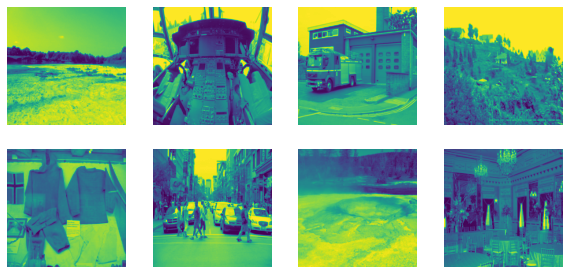

In [22]:
plt.figure(figsize = (10, 10))
for i in range(8):
  plt.subplot(4, 4, i + 1)
  plt.axis('off')
  plt.imshow(X_[i])

- **InstantiateModel():** Building our CNN model based on the Zhang paper.

In [23]:
K.clear_session()
def InstantiateModel(in_):
    #conv 1
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(in_)
    model_ = ReLU()(model_)
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    #conv 2
    model_ = Conv2D(128,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(128,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    #conv 3
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    #conv 4
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    #conv 5
    model_ = Conv2D(512,(3,3),padding="same",dilation_rate=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",dilation_rate=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",dilation_rate=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    #conv 6
    model_ = Conv2D(512,(3,3),dilation_rate=(2, 2),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),dilation_rate=(2, 2),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),dilation_rate=(2, 2),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    #model 7
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
        
    #model 8
    model_ = Conv2DTranspose(256,(4,4),padding="same",strides=2,use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)

    model_ = Conv2D(313,(1,1),padding='valid',use_bias=True)(model_)
    model_ = Softmax()(model_)
    model_ = Conv2D(2,(1,1),padding='valid')(model_)
    model_ = UpSampling2D((2,2))(model_)
    return model_

In [24]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)

In [25]:
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [26]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=SGD(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 128)     73856 

- **GenerateInputs():** Using the **L** channel as the input to the network and train the network to predict the **ab** channels.

In [39]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,HEIGHT,WIDTH,1)
        y_input = y_[i].reshape(1,HEIGHT,WIDTH,2)
        yield (X_input,y_input)
hist = Model_Colourization.fit(GenerateInputs(X_,y_), epochs = 25, verbose = 1, steps_per_epoch = 513, batch_size = 64, shuffle = True)

Epoch 1/25
513/513 [==============================] - 4231s 8s/step - loss: 1219.6493
Epoch 2/25
513/513 [==============================] - 4124s 8s/step - loss: 889.2170
Epoch 3/25
513/513 [==============================] - 4322s 8s/step - loss: 766.0377
Epoch 4/25
513/513 [==============================] - 4246s 8s/step - loss: 687.4914
Epoch 5/25
513/513 [==============================] - 4442s 9s/step - loss: 589.5799
Epoch 6/25
513/513 [==============================] - 4135s 8s/step - loss: 540.2778
Epoch 7/25
513/513 [==============================] - 4257s 8s/step - loss: 503.5786
Epoch 8/25
513/513 [==============================] - 4222s 8s/step - loss: 466.7874
Epoch 9/25
513/513 [==============================] - 4167s 8s/step - loss: 420.5874
Epoch 10/25
513/513 [==============================] - 4345s 8s/step - loss: 377.7910
Epoch 11/25
513/513 [==============================] - 4307s 8s/step - loss: 342.1821
Epoch 12/25
513/513 [==============================] - 4298s 8

- **ExtractTestInput():** Merging back the **L** and **ab** channels.
- **PrintImage():** Displaying the grayscale image, predicted image and and grounf truth.

In [35]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT))
    img_l = img_lab_rs[:,:,0]
    img_l_reshaped = img_l.reshape(1,HEIGHT,WIDTH,1)
    return img_l_reshaped

def PrintImage(ImagePath):
    #ImagePath = testdata[0]
    image_for_test = ExtractTestInput(ImagePath)
    Prediction = Model_Colourization.predict(image_for_test)
    Prediction = Prediction * 128
    Prediction = Prediction.reshape(224, 224, 2)

    plt.figure(figsize = (30, 20))
    plt.subplot(5, 5, 1)
    img_1 = cv2.imread(ImagePath)
    img_1 = cv2.resize(img_1, (224, 224))
    img2 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    #img2 = cv2.resize(img2, (224, 224))
    plt.title("Gray Image")
    plt.axis('off')
    plt.imshow(img2, cmap = 'Greys_r')

    plt.subplot(5, 5, 2)
    img_ = cv2.cvtColor(img_1, cv2.COLOR_BGR2Lab)
    img_[:,:,1:] = Prediction
    img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
    plt.title("Predicted Image")
    plt.axis('off')
    plt.imshow(img_)

    plt.subplot(5, 5, 3)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

### PREDICTED IMAGES

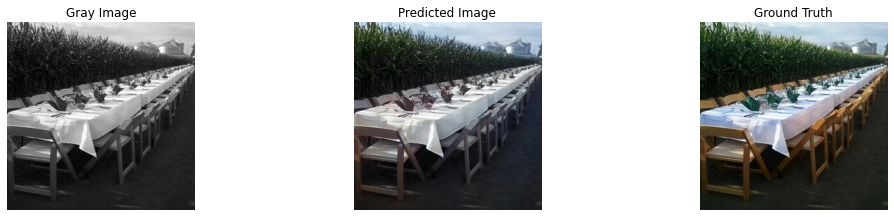

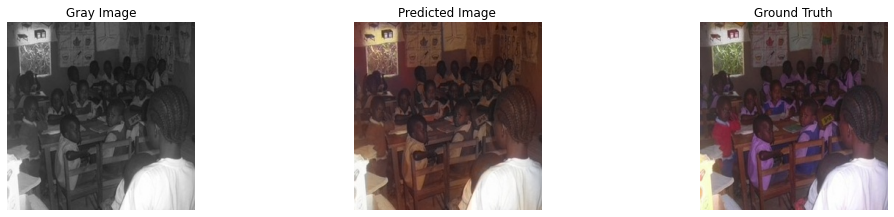

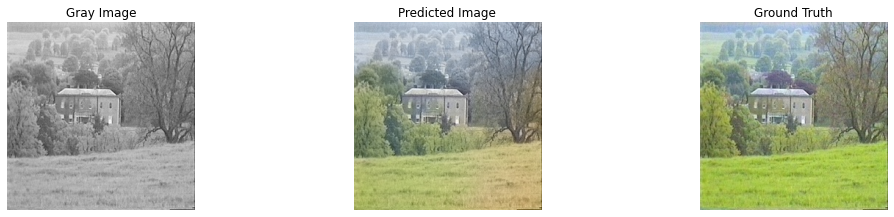

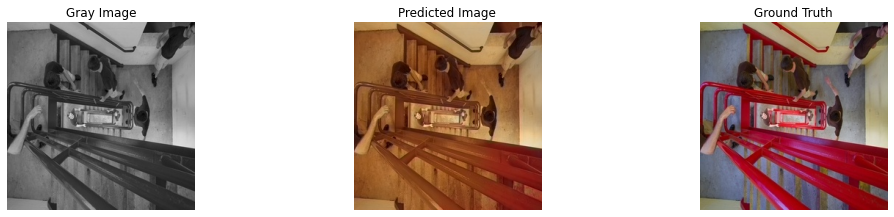

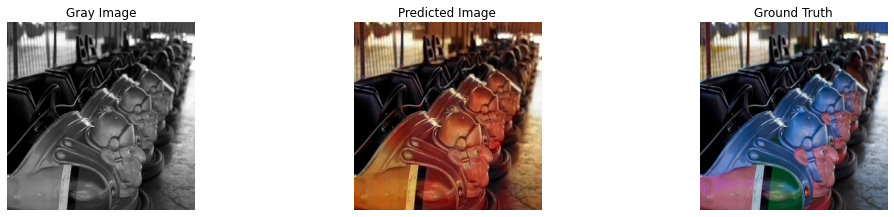

In [37]:
PrintImage(testdata[0])
PrintImage(testdata[1])
PrintImage(testdata[2])
PrintImage(testdata[3])
PrintImage(testdata[4])